In [24]:
import pandas as pd
import gower
import numpy as np

from sklearn.model_selection import train_test_split

## Loading the datasets
We load the datasets, we decided to split them into 3 different datasets and concatenate them later on based the use case. The concatination step is done before any preprocessing.

TODO from 12.05.2025 21:54 (add more and when chaning the todo add a new date)
- encode target variabels
- remove columns Smoke(bad representation + small correlation value) and SCC(bad representation aswell, unsure about correlation value (0.224), have a discussion about it.)


In [25]:
# Load the raw data

TEST_SIZE = 0.2

raw_pseudoreal_data = pd.read_csv("./datasets/real-data-20250501-154339.csv")

# Split the data into actual real data and generated with SMOTE(pseudoreal)
raw_real_data = raw_pseudoreal_data[0:477]
raw_pseudoreal_data = raw_pseudoreal_data[478:]

# Synthetic data generated using DeepLearning model
raw_synthetic_data = pd.read_csv("./synth.csv")
raw_synthetic_data = raw_synthetic_data.drop(columns=['id'])

# Print the shape of the datasets
print(f"Shape of raw_real_data: {raw_real_data.shape}")
print(f"Shape of raw_pseudoreal_data: {raw_pseudoreal_data.shape}")
print(f"Shape of synthetic_data: {raw_synthetic_data.shape}")

Shape of raw_real_data: (477, 17)
Shape of raw_pseudoreal_data: (1633, 17)
Shape of synthetic_data: (20758, 17)


## Gower distance
to remove similar records between the pseudoreal-real dataset and synth, we use Gowers similarity measure. The function below removes the similarities between the test set and the synthetical dataset, so that information leakage can be handled accordingly. 

In [26]:
# Function to remove similarities based on Gower distance
def remove_similar(X_test, synth, threshold=.2):
    '''
    Remove similarities between real and synthetic data

    Parameters
    ----------
    X_test : DataFrame
        Test data
    synth : DataFrame
        Synthetic data
    threshold : float, optional
        Threshold for similarity, by default .2
        
    Returns
    -------
    DataFrame
        Synthetic data without similar records
    dict
        Map of removed records
    '''
    to_remove = []
    removed_map = {}

    for i, row in X_test.iterrows():
        # Compute Gower distance between the real record and the synthetic data
        gower_matrix = gower.gower_matrix(row.to_frame().T, synth)
        # Find indices of synthetic records within the threshold
        matches = np.where(gower_matrix <= threshold)
        unique_indices = np.unique(matches[1])
        
        # Save the indices of the removed records
        for idx in unique_indices:
            removed_map.setdefault(idx, []).append(i)

        # Save removed indices for later analysis (number of removed records)    
        to_remove.extend(unique_indices)
    
    # Remove found similarities from synthetic data
    synth = synth.drop(index=to_remove)
    print(f"Removed {len(to_remove)} similar records from synthetic data.")

    return synth, removed_map


Removing a row since it has only 1 entry of it over all the datasets

In [27]:
# Remove rows where the column 'CALC' has the value 'Always'
filtered_data = raw_real_data[raw_real_data['CALC'] != 'Always']


## Initial data split
we splitted the data initially between pseudoreal-real and synth data, because at this point we haven't noticed the problem with the dataset. In this format the test-set that we use for comparison is created from the pseudoreal-real dataset. 

In [28]:
# Split the data into train and test sets for different approaches
# Initial approach: train on real+pseudoreal, train on real+pseudoreal+synthetic, test on split real+pseudoreal
# Extra approach: train on real, train on real+pseudoreal, train on real+pseudoreal+synthetic, test on split real

# Save all splits in a dictionary
data = {
    'Initial': {},
    'Extra': {}
}


# Initial approach

# Real + pseudoreal data based on different train/test split
real_pseudoreal_data = pd.concat([raw_real_data, raw_pseudoreal_data])
X_real_pseudoreal = real_pseudoreal_data.drop(columns=['NObeyesdad'])
Y_real_pseudoreal = real_pseudoreal_data['NObeyesdad']
X_train_real_pseudoreal, X_test_real_pseudoreal, y_train_real_pseudoreal, y_test_real_pseudoreal = train_test_split(
    X_real_pseudoreal, Y_real_pseudoreal, test_size=TEST_SIZE, random_state=42, stratify=Y_real_pseudoreal)

data['Initial']['real_train'] = {
    'X': X_train_real_pseudoreal,
    'y': y_train_real_pseudoreal
}

# Test split on real + pseudoreal
data['Initial']['test'] = {
    'X': X_test_real_pseudoreal,
    'y': y_test_real_pseudoreal
}

# Remove similarities between real and synthetic data
real_pseudoreal_test = pd.concat([X_test_real_pseudoreal, y_test_real_pseudoreal], axis=1)
synthetic_data_clean, removed_map = remove_similar(real_pseudoreal_test, raw_synthetic_data)

# Real + pseudoreal + synthetic train (different from the train set below)
X_synth = synthetic_data_clean.drop(columns=['NObeyesdad'])
y_synth = synthetic_data_clean['NObeyesdad']
X_real_pseudoreal_synth = pd.concat([X_train_real_pseudoreal, X_synth])
Y_real_pseudoreal_synth = pd.concat([y_train_real_pseudoreal, y_synth])


data['Initial']['synth_train'] = {
    'X': X_real_pseudoreal_synth,
    'y': Y_real_pseudoreal_synth
}


Removed 2410 similar records from synthetic data.


## Extra data split
In this step we split the data three ways, since we saw the flaw in the data. According to the paper we found online, where the dataset originates from:
<ul>
<li>entries 0-477 from "real-data.csv" are from a survey, we named them <strong>real</strong>.</li>
<li>entries 478-2111 from "real-data.csv" are created by SMOTE to even out the target class distribution, we named them <strong>pseudoreal</strong>.</li>
<li>the 20758 entries from "synth.csv" are created by a DL model, which isnt specified, so we named them <strong>synth</strong>.</li>
</ul>

In [29]:

# Extra approach

X_real = raw_real_data.drop(columns=['NObeyesdad'])
y_real = raw_real_data['NObeyesdad']

# Real Real data 477, splitted
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=TEST_SIZE, random_state=42, stratify=y_real)

data['Extra']['real_train'] = {
    'X': X_train_real,
    'y': y_train_real,
}

# Test split on real data only
data['Extra']['test'] = {
    'X': X_test_real,
    'y': y_test_real
}

# Only pseudoreal data ~1666
X_pseudoreal = raw_pseudoreal_data.drop(columns=['NObeyesdad'])
y_pseudoreal = raw_pseudoreal_data['NObeyesdad']

# Real + pseudoreal train
X_pseudoreal_real = pd.concat([X_train_real, X_pseudoreal])
y_pseudoreal_real = pd.concat([y_train_real, y_pseudoreal])

data['Extra']['real_pseudoreal_train'] = {
    'X': X_pseudoreal_real,
    'y': y_pseudoreal_real,
}

# Remove similarities between real test data and synthetic data
real_test = pd.concat([X_test_real, y_test_real], axis=1)
synthetic_data_clean, removed_map = remove_similar(real_test, raw_synthetic_data)

# Only synthetic data ~20k
X_synth = synthetic_data_clean.drop(columns=['NObeyesdad'])
y_synth = synthetic_data_clean['NObeyesdad']

# Real + pseudoreal + synthetic train
X_synth_pseudoreal_real = pd.concat([X_pseudoreal_real, X_synth])
Y_synth_pseudoreal_real = pd.concat([y_pseudoreal_real, y_synth])


data['Extra']['real_pseudoreal_synth_train'] = {
    'X': X_synth_pseudoreal_real,
    'y': Y_synth_pseudoreal_real,
}


Removed 628 similar records from synthetic data.


We split the features in categories

In [30]:
# Define features for preprocessing

# Numeric features with rounding to int
numeric_features_int = ['Age']
# Numeric features with rounding to 2 decimal places
numeric_features_2dp = ['Height']
# Boolean features
boolean_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
# Categorical features
categorical_features = ['Gender', 'MTRANS']
# Ordinal features with rounding to int
ordinal_features_int = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
# Ordinal features with mapping to int
ordinal_features_map_int = ['CAEC', 'CALC']
# Drop features (Just for the info)
drop_features = ['Weight']

## Preprocessor
We define custom preprocessors here and also align them in a pipeline, for more clarity. Afterwards we assign them to a columntransformer, so that the preprocessing step can be done easily on multiple similar datasets.

In [ ]:
# Create preprocessing pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Numerical tranformer
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, round_type='int'):
        self.scaler = StandardScaler()
        self.round_type = round_type
        self.features = []
    
    def _round(self, X):
        if self.round_type == 'int':
            return np.round(X).astype(int)
        elif self.round_type == 'float':
            return np.round(X, 2)
        return X    

    def fit(self, X, y=None):
        X_rounded = self._round(X)
        self.scaler.fit(X_rounded)
        self.features = X.columns.tolist()
        return self

    def transform(self, X):
        X_rounded = self._round(X)
        return self.scaler.transform(X_rounded)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.features)


# Boolean transformer
class BooleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = []

    def fit(self, X, y=None):
        self.features = X.columns.tolist()
        return self

    def transform(self, X):
        return X.replace({'yes': 1, 'no': 0})
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.features)


# Ordinal transformer
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rounding=False):
        self.rounding = rounding
        self.mapping = {
            'no': 0,
            'Sometimes': 1,
            'Frequently': 2,
            'Always': 3
        }
        self.features = []

    def fit(self, X, y=None):
        self.features = X.columns.tolist()
        return self

    def transform(self, X):
        if self.rounding:
            return np.round(X).astype(int)
        else:
            return X.replace(self.mapping)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.features)
   

# Numeric int pipeline
numeric_int_pipeline = Pipeline(steps=[
    ('scaler_int', NumericalTransformer(round_type='int'))
])

# Numeric 2dp pipeline
numeric_2dp_pipeline = Pipeline(steps=[
    ('scaler_2dp', NumericalTransformer(round_type='float'))
])

# Boolean pipeline
boolean_pipeline = Pipeline(steps=[
    ('boolean', BooleanTransformer())
])

# Ordinal int pipeline
ordinal_int_pipeline = Pipeline(steps=[
    ('ordinal_int', OrdinalTransformer(rounding=True))
])

# Ordinal map int pipeline
ordinal_map_int_pipeline = Pipeline(steps=[
    ('ordinal_map', OrdinalTransformer(rounding=False))
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_int', numeric_int_pipeline, numeric_features_int),
        ('numeric_2dp', numeric_2dp_pipeline, numeric_features_2dp),
        ('boolean', boolean_pipeline, boolean_features),
        ('ordinal_int', ordinal_int_pipeline, ordinal_features_int),
        ('ordinal_map_int', ordinal_map_int_pipeline, ordinal_features_map_int),
        ('categorical', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)


We use the preprocessor defined above for every training dataset

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder

# Preprocess the data
for approach, datasets in data.items():
    for name, dataset in datasets.items():
        if 'train' in name:
            
            X = dataset['X']
            # Fit the preprocessor on the training data
            preprocessor.fit(X)
            
            # Transform the training and test data
            X_train = preprocessor.transform(X)
            X_test = preprocessor.transform(datasets['test']['X'])
            

            # Encode the target variable
            le = LabelEncoder()
            le.fit(dataset['y'])
            y_train = pd.DataFrame(le.transform(dataset['y']))
            y_test = pd.DataFrame(le.transform(datasets['test']['y']))
            
            # Convert to DataFrame
            X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
            X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
            
            # Save the preprocessed data
            folder = f"./datasets/preprocessed/{approach}/{name.replace('train', 'data')}/"
            os.makedirs(folder, exist_ok=True)
            X_train.to_csv(os.path.join(folder, "X_train.csv"), index=False)
            y_train.to_csv(os.path.join(folder, "y_train.csv"), index=False)
            X_test.to_csv(os.path.join(folder, "X_test.csv"), index=False)
            y_test.to_csv(os.path.join(folder, "y_test.csv"), index=False)
            print(f"Preprocessed data saved for {approach} - {name}")
        
            




C:\Users\Denis\AppData\Local\Temp\ipykernel_17380\993651992.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace({'yes': 1, 'no': 0})
C:\Users\Denis\AppData\Local\Temp\ipykernel_17380\993651992.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will rai

Preprocessed data saved for Initial - real_train
Preprocessed data saved for Initial - synth_train
Preprocessed data saved for Extra - real_train
Preprocessed data saved for Extra - real_pseudoreal_train


C:\Users\Denis\AppData\Local\Temp\ipykernel_17380\993651992.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace({'yes': 1, 'no': 0})
C:\Users\Denis\AppData\Local\Temp\ipykernel_17380\993651992.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will rai

Preprocessed data saved for Extra - real_pseudoreal_synth_train


c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 18
[LightGBM] [Info] Start training from score -2.051402
[LightGBM] [Info] Start training from score -1.997578
[LightGBM] [Info] Start training from score -1.792945
[LightGBM] [Info] Start training from score -1.959029
[LightGBM] [Info] Start training from score -1.874472
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 20717, number of used features: 20
[LightGBM] [Info] Start training from score -2.121084
[LightGBM] [Info] Start training from score -1.951185
[LightGBM] [Info] Start training from score -1.940039
[LightGBM] [Info] Start training from score -1.794902
[LightGBM] [Info] Start training from score -1.700702
[LightGBM] [Info] Start training from score -2.138137
[LightGBM] [Info] Start training from score -2.057906
Initial - synth_data - Accuracy: 0.8246, F1 Score: 0.8223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 18
[LightGBM] [Info] Start training from score -2.028148
[LightGBM] [Info] Start training from score -2.165460
[LightGBM] [Info] Start training from score -1.773067
[LightGBM] [Info] Start training from score -1.920903
[LightGBM] [Info] Start training from score -1.830226
[LightGBM] [Info] Start training from score -1.976666
[LightGBM] [Info] Start training from score -1.976666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Extra - real_pseudoreal_data - Accuracy: 0.5521, F1 Score: 0.5496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wis

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Extra - real_pseudoreal_synth_data - Accuracy: 0.4792, F1 Score: 0.4830


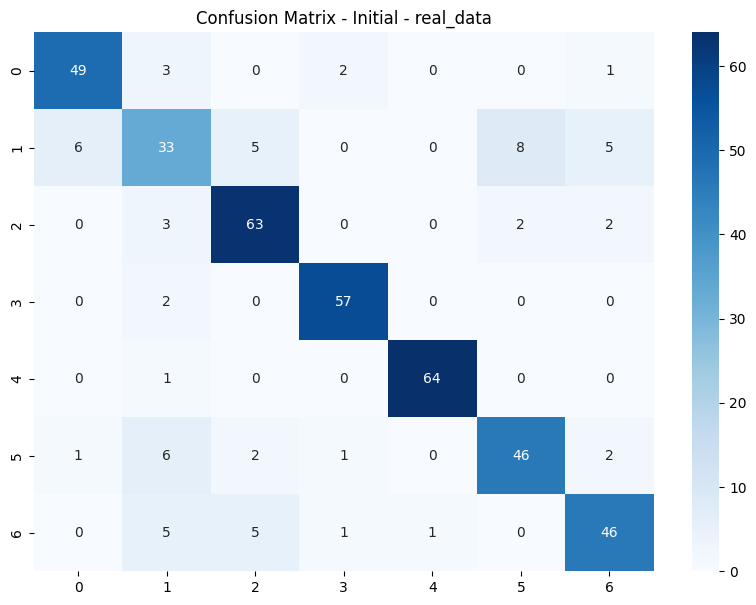

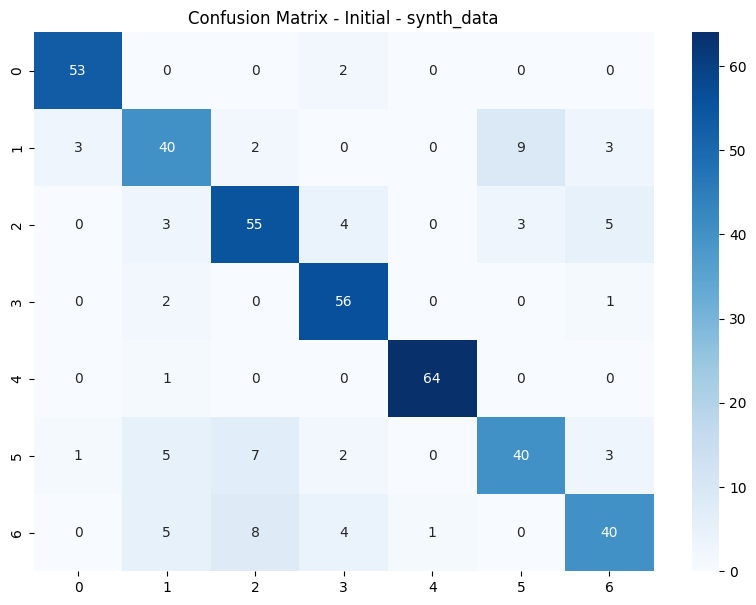

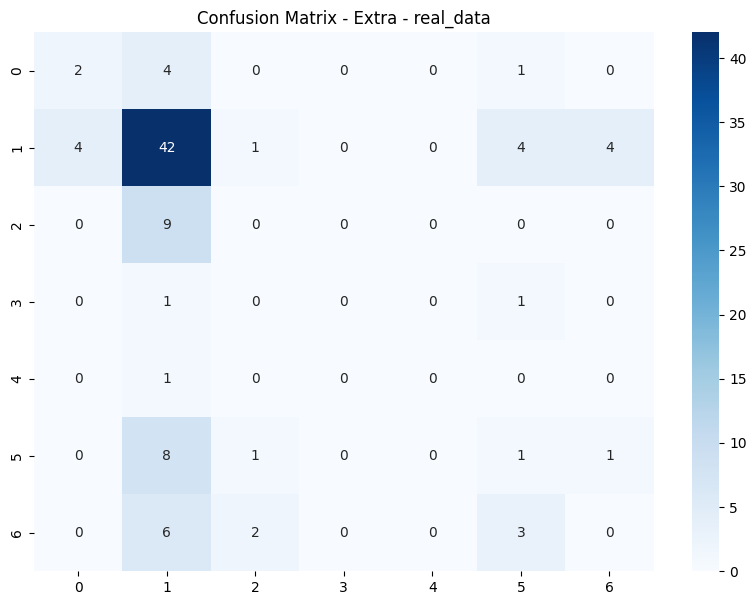

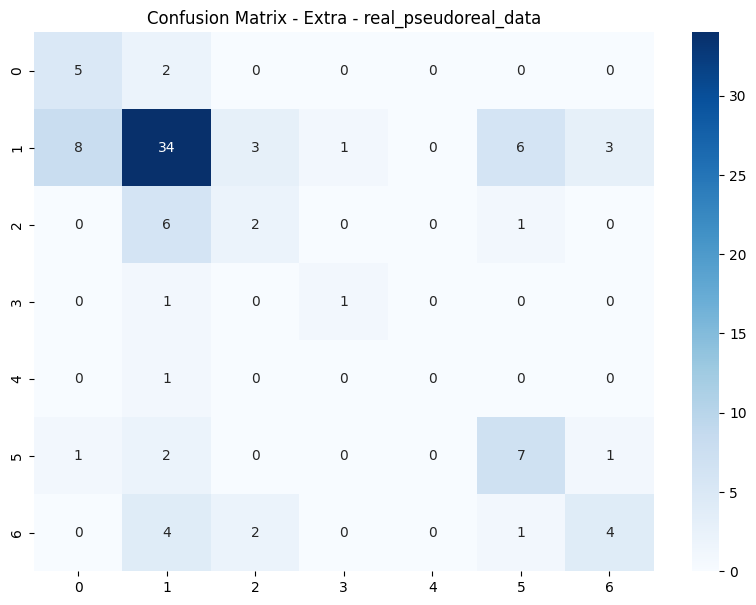

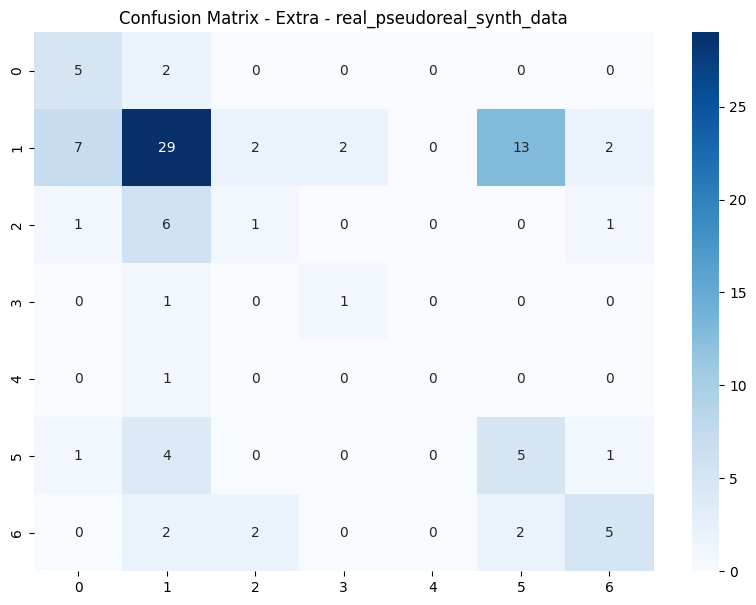

In [41]:
# Train and test the lgbm model for all existing datasets
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Function to train and test the model
def train_and_test_model(X_train, y_train, X_test, y_test):
    # Create the model
    model = lgb.LGBMClassifier()

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)


    return accuracy, f1, cm

# Train and test the model for all datasets
approaches = {'Initial': ['real_data', 'synth_data'], 'Extra': ['real_data', 'real_pseudoreal_data', 'real_pseudoreal_synth_data']}

for approach, datasets in approaches.items():
    for dataset in datasets:
        # Load the preprocessed data
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_train.csv")
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_test.csv")

        

        
        # Train and test the model
        accuracy, f1, cm = train_and_test_model(X_train, y_train, X_test, y_test)
        
        # Print the results in green color
        print(f"\033[92m{approach} - {dataset} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}\033[0m")
        
        # Plot confusion matrix
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f"Confusion Matrix - {approach} - {dataset}")
        
        

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 1688, number of used features: 18
[LightGBM] [Info] Start training from score -2.051402
[LightGBM] [Info] Start training from score -1.997578
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Info] Start training from score -1.984562
[LightGBM] [Info] Start training from score -1.792945
[LightGBM] [Info] Start training from score -1.959029
[LightGBM] [Info] Start training from score -1.874472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

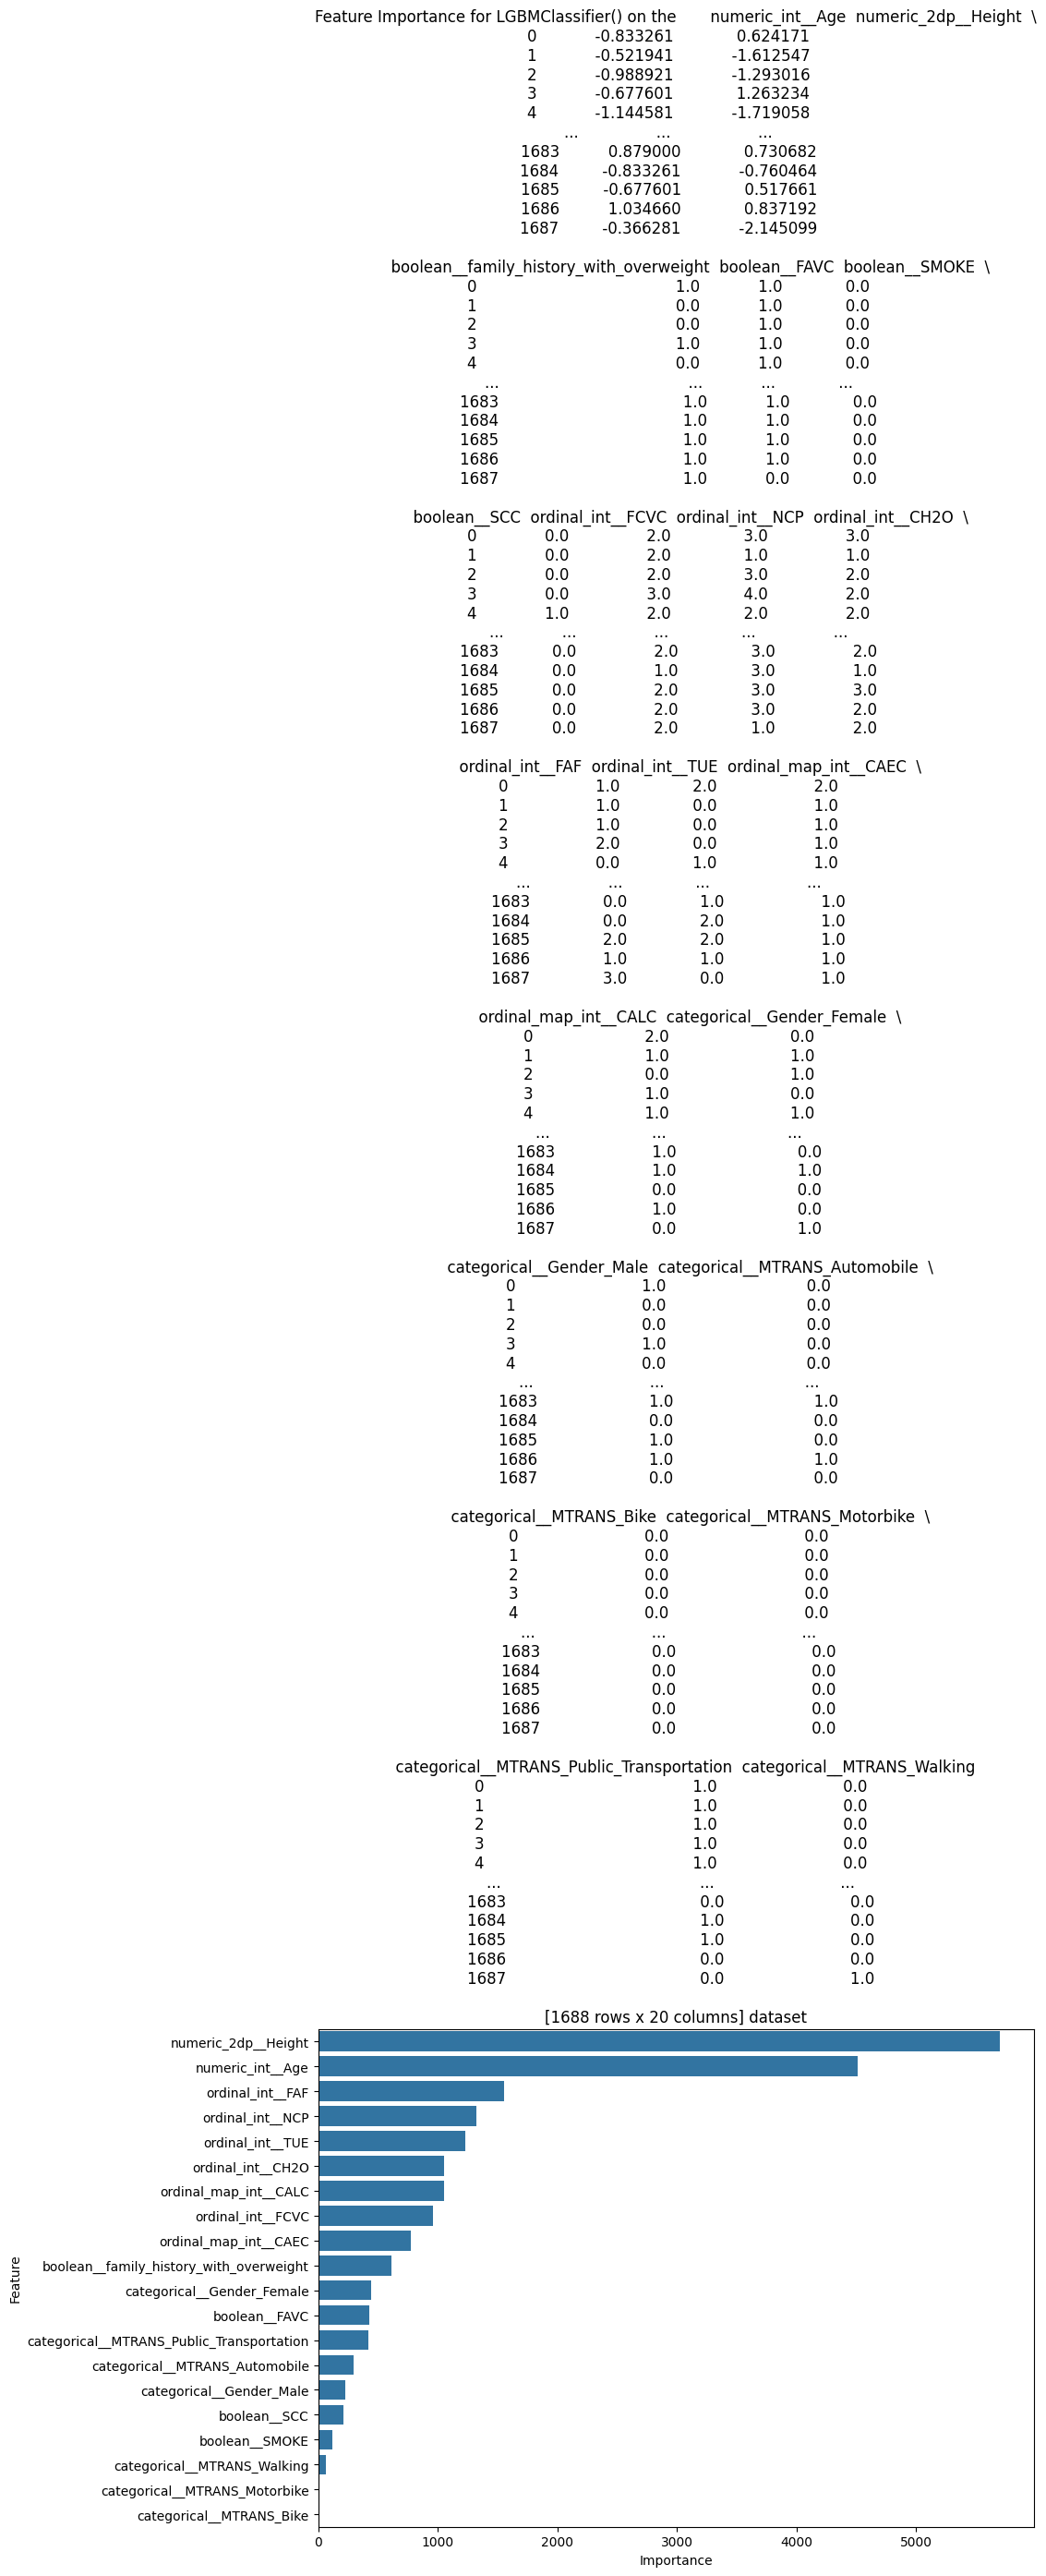

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 20717, number of used features: 20
[LightGBM] [Info] Start training from score -2.121084
[LightGBM] [Info] Start training from score -1.951185
[LightGBM] [Info] Start training from score -2.138137
[LightGBM] [Info] Start training from score -2.057906
[LightGBM] [Info] Start training from score -1.940039
[LightGBM] [Info] Start training from score -1.794902
[LightGBM] [Info] Start training from score -1.700702


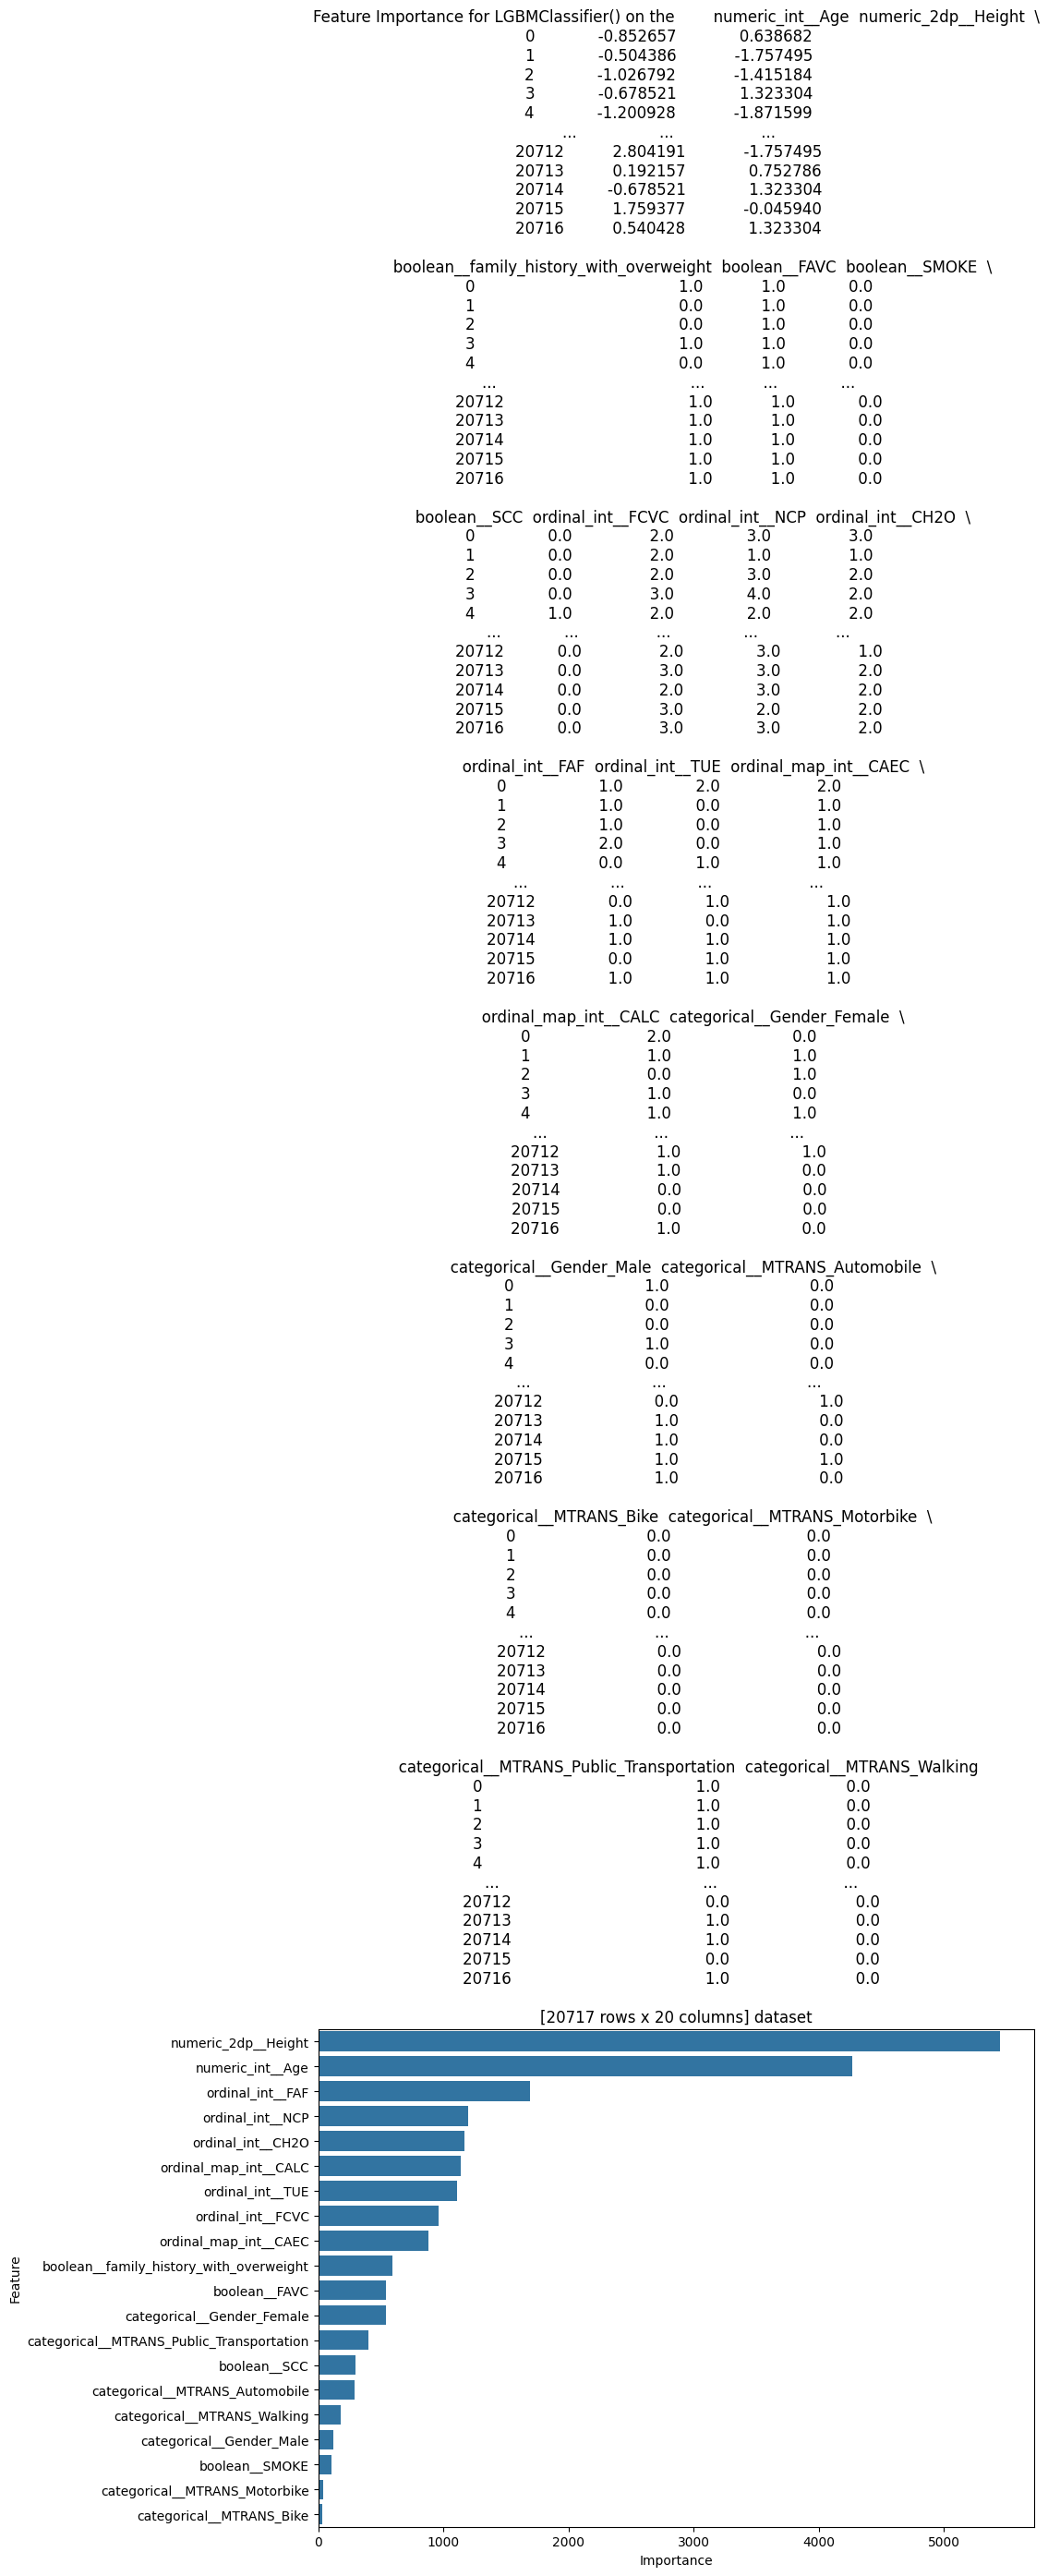

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 381, number of used features: 18
[LightGBM] [Info] Start training from score -2.684703
[LightGBM] [Info] Start training from score -0.562902
[LightGBM] [Info] Start training from score -2.114158
[LightGBM] [Info] Start training from score -2.158610
[LightGBM] [Info] Start training from score -2.331881
[LightGBM] [Info] Start training from score -3.745575
[LightGBM] [Info] Start training from score -5.249652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

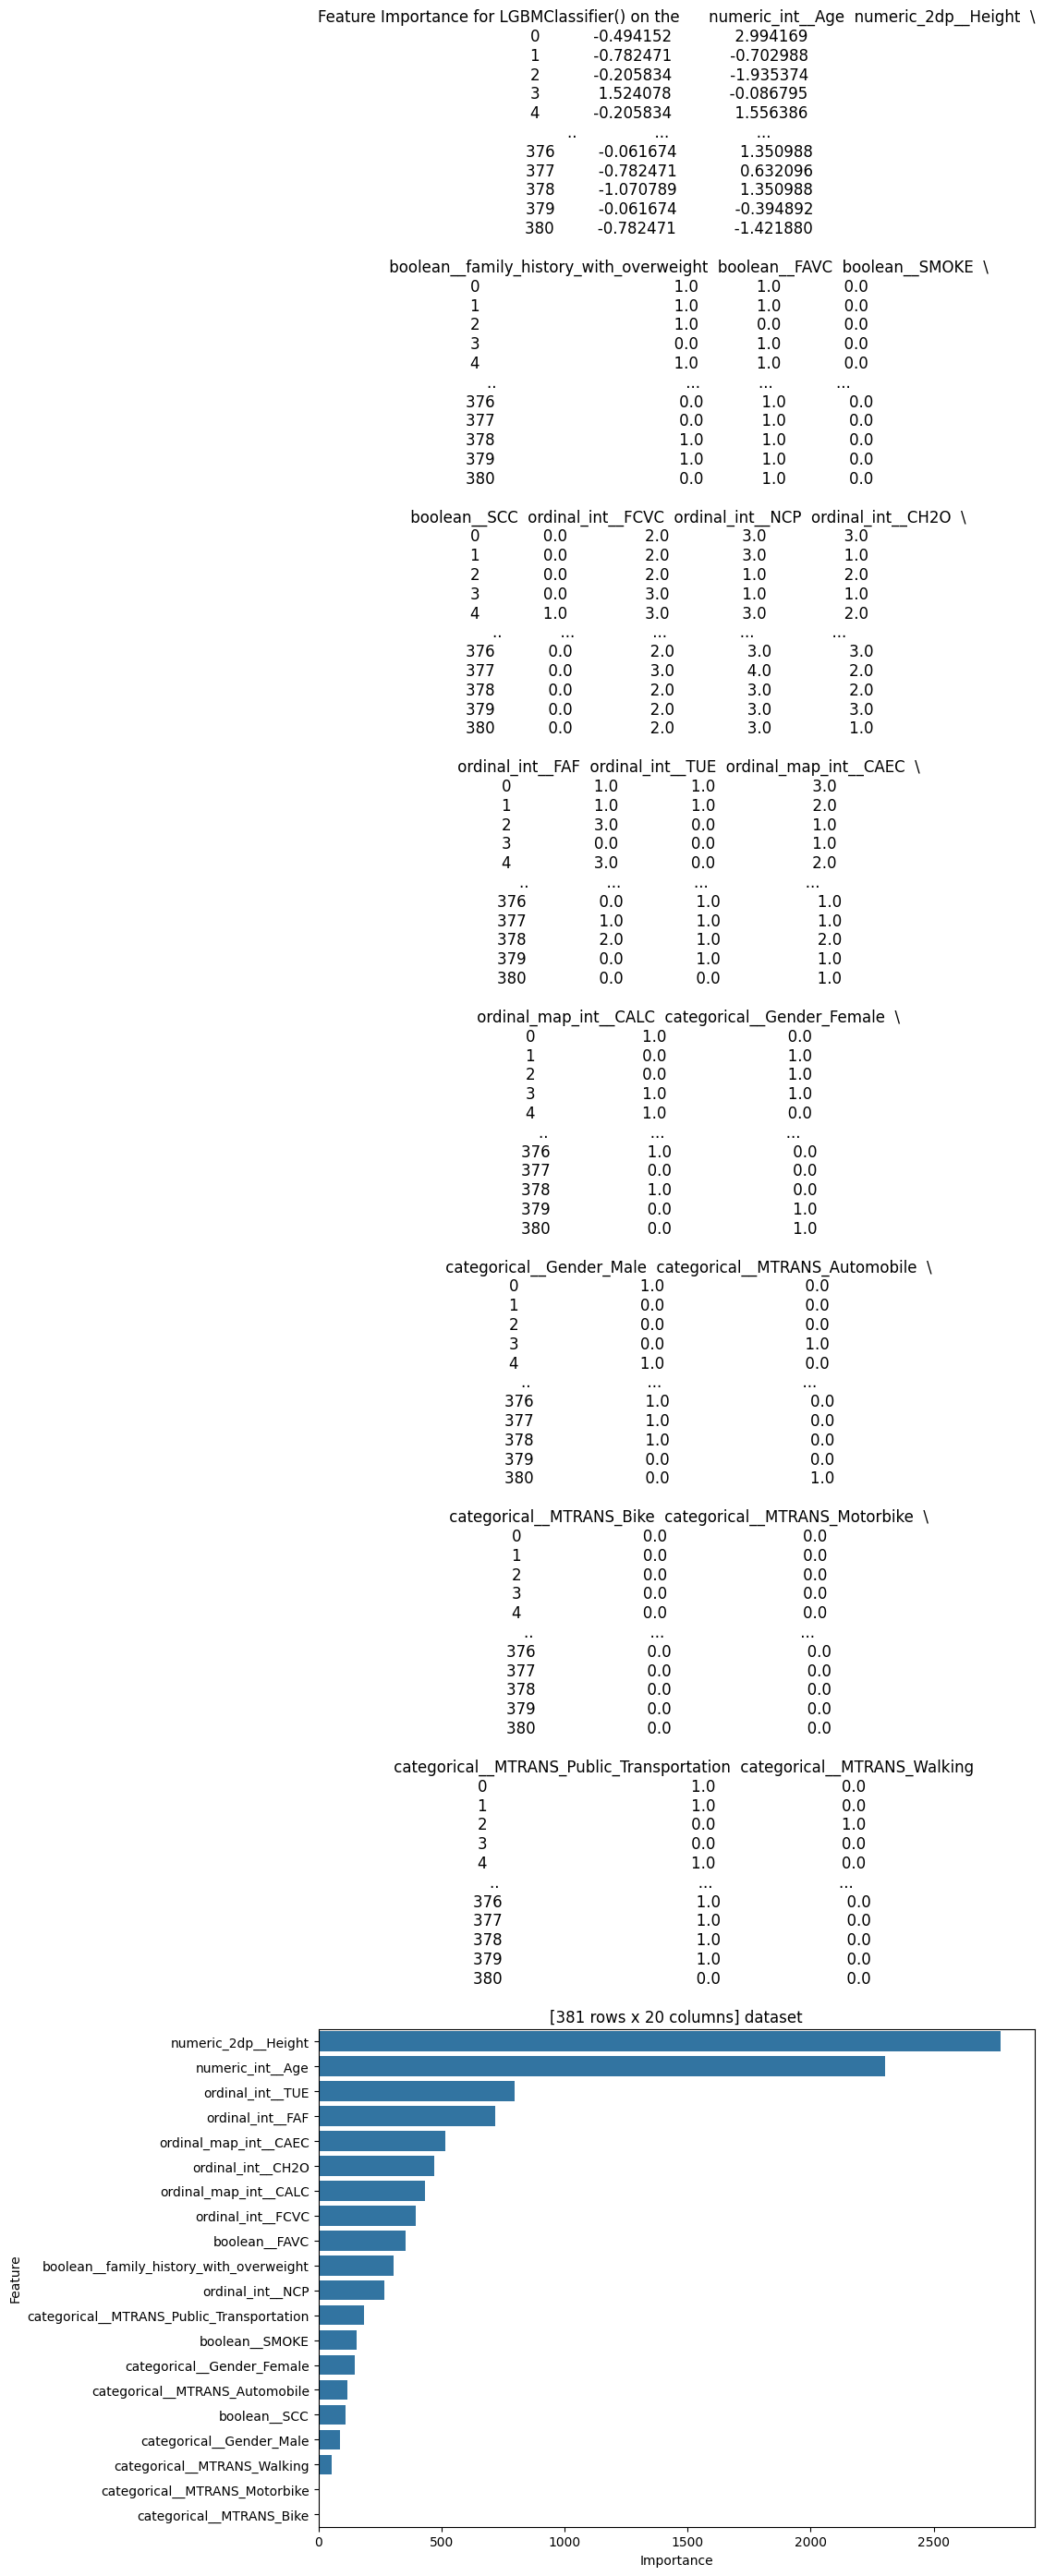

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 18
[LightGBM] [Info] Start training from score -2.028148
[LightGBM] [Info] Start training from score -2.165460
[LightGBM] [Info] Start training from score -1.976666
[LightGBM] [Info] Start training from score -1.976666
[LightGBM] [Info] Start training from score -1.773067
[LightGBM] [Info] Start training from score -1.920903
[LightGBM] [Info] Start training from score -1.830226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


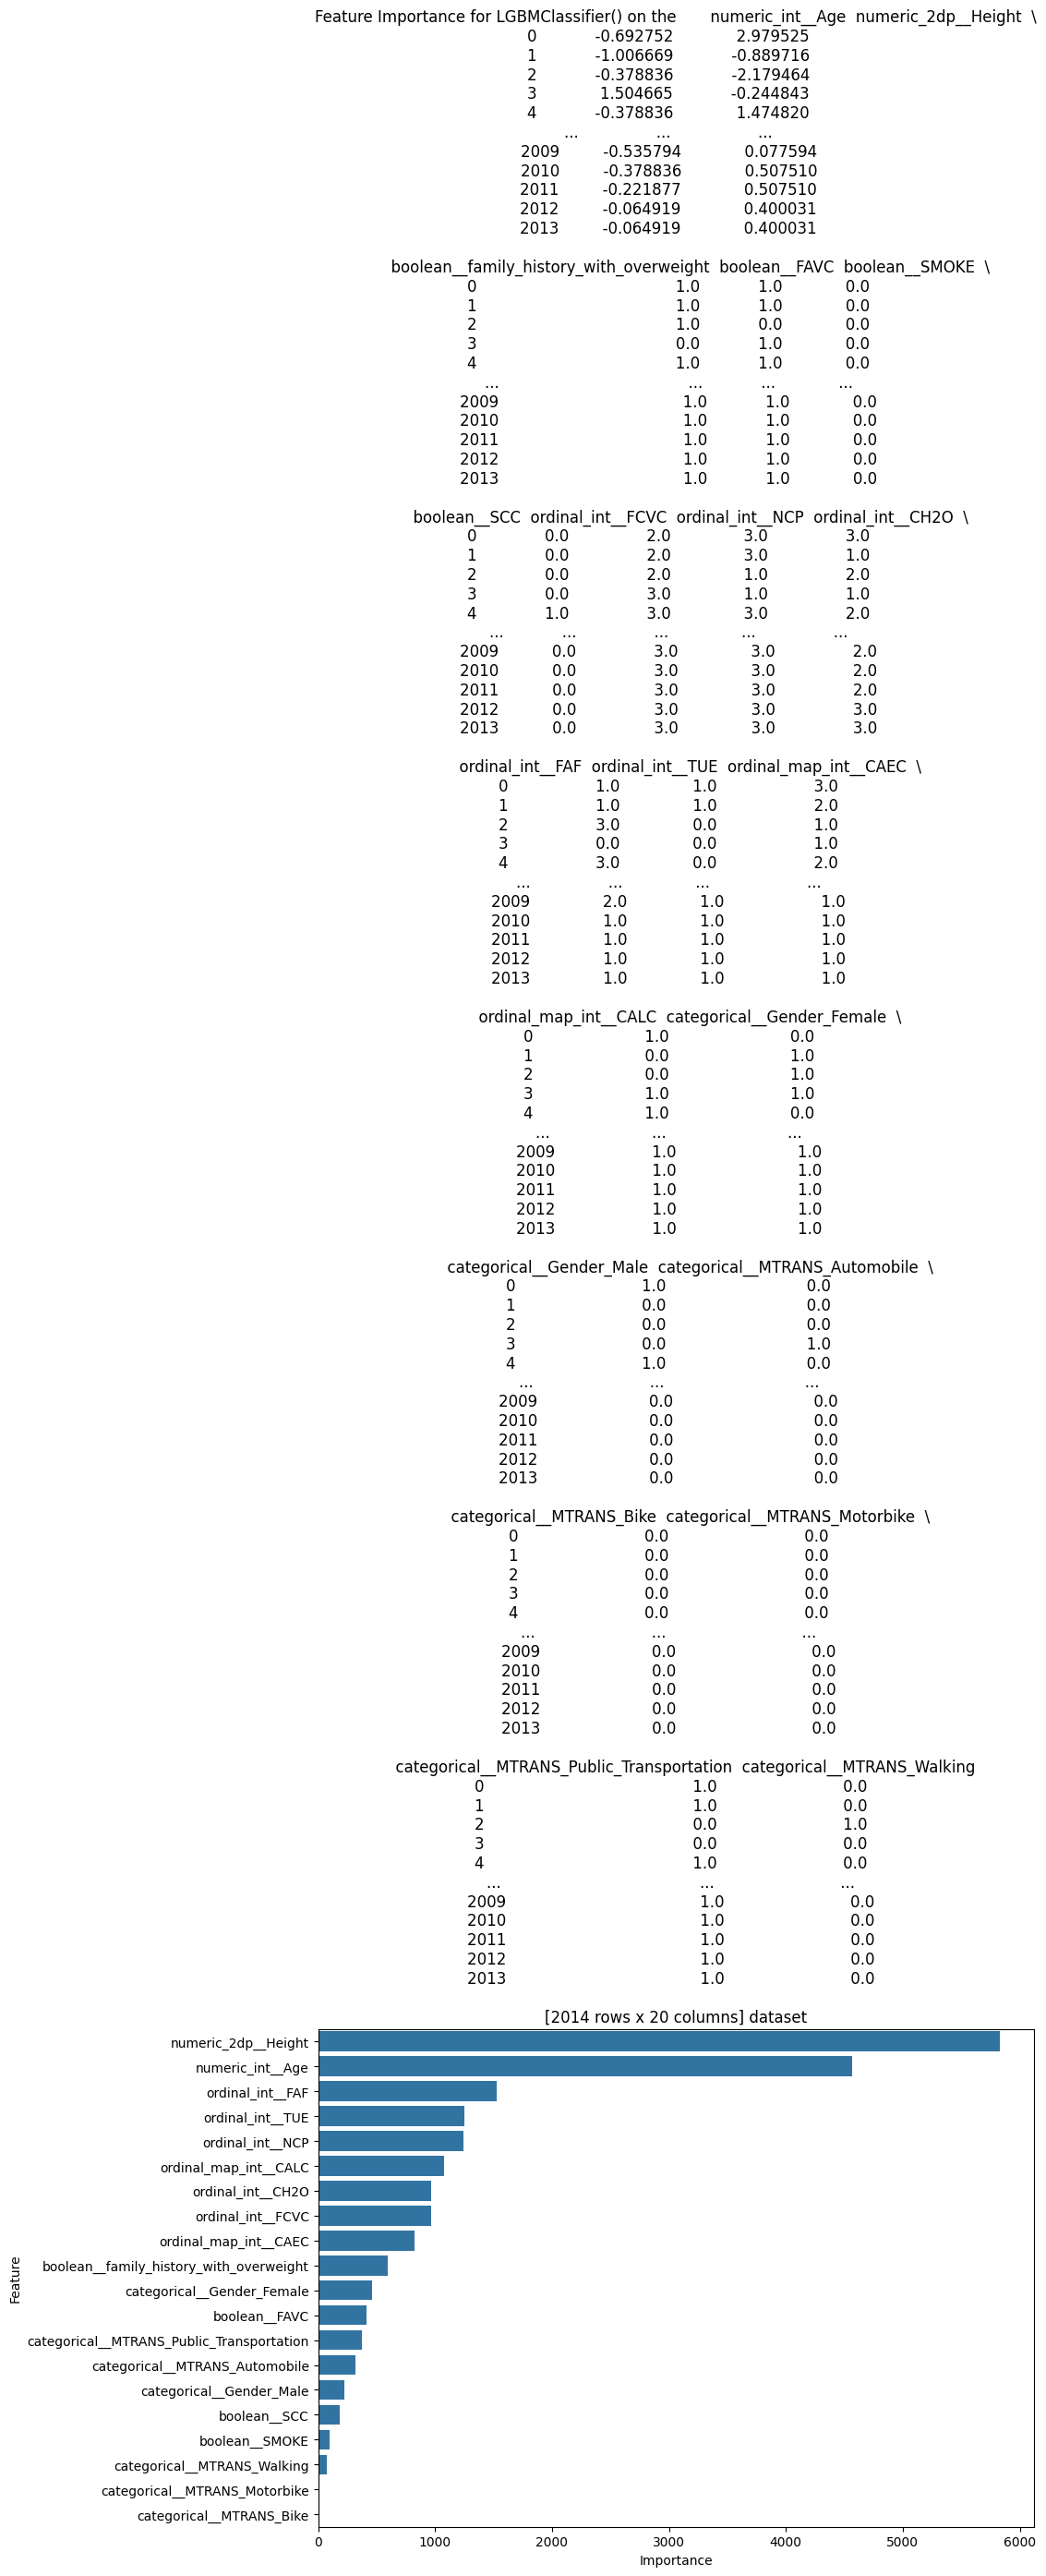

c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Denis\envs\datamining\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 22175, number of used features: 20
[LightGBM] [Info] Start training from score -2.110168
[LightGBM] [Info] Start training from score -2.003023
[LightGBM] [Info] Start training from score -2.142685
[LightGBM] [Info] Start training from score -2.081925
[LightGBM] [Info] Start training from score -1.930516
[LightGBM] [Info] Start training from score -1.834274
[LightGBM] [Info] Start training from score -1.624431


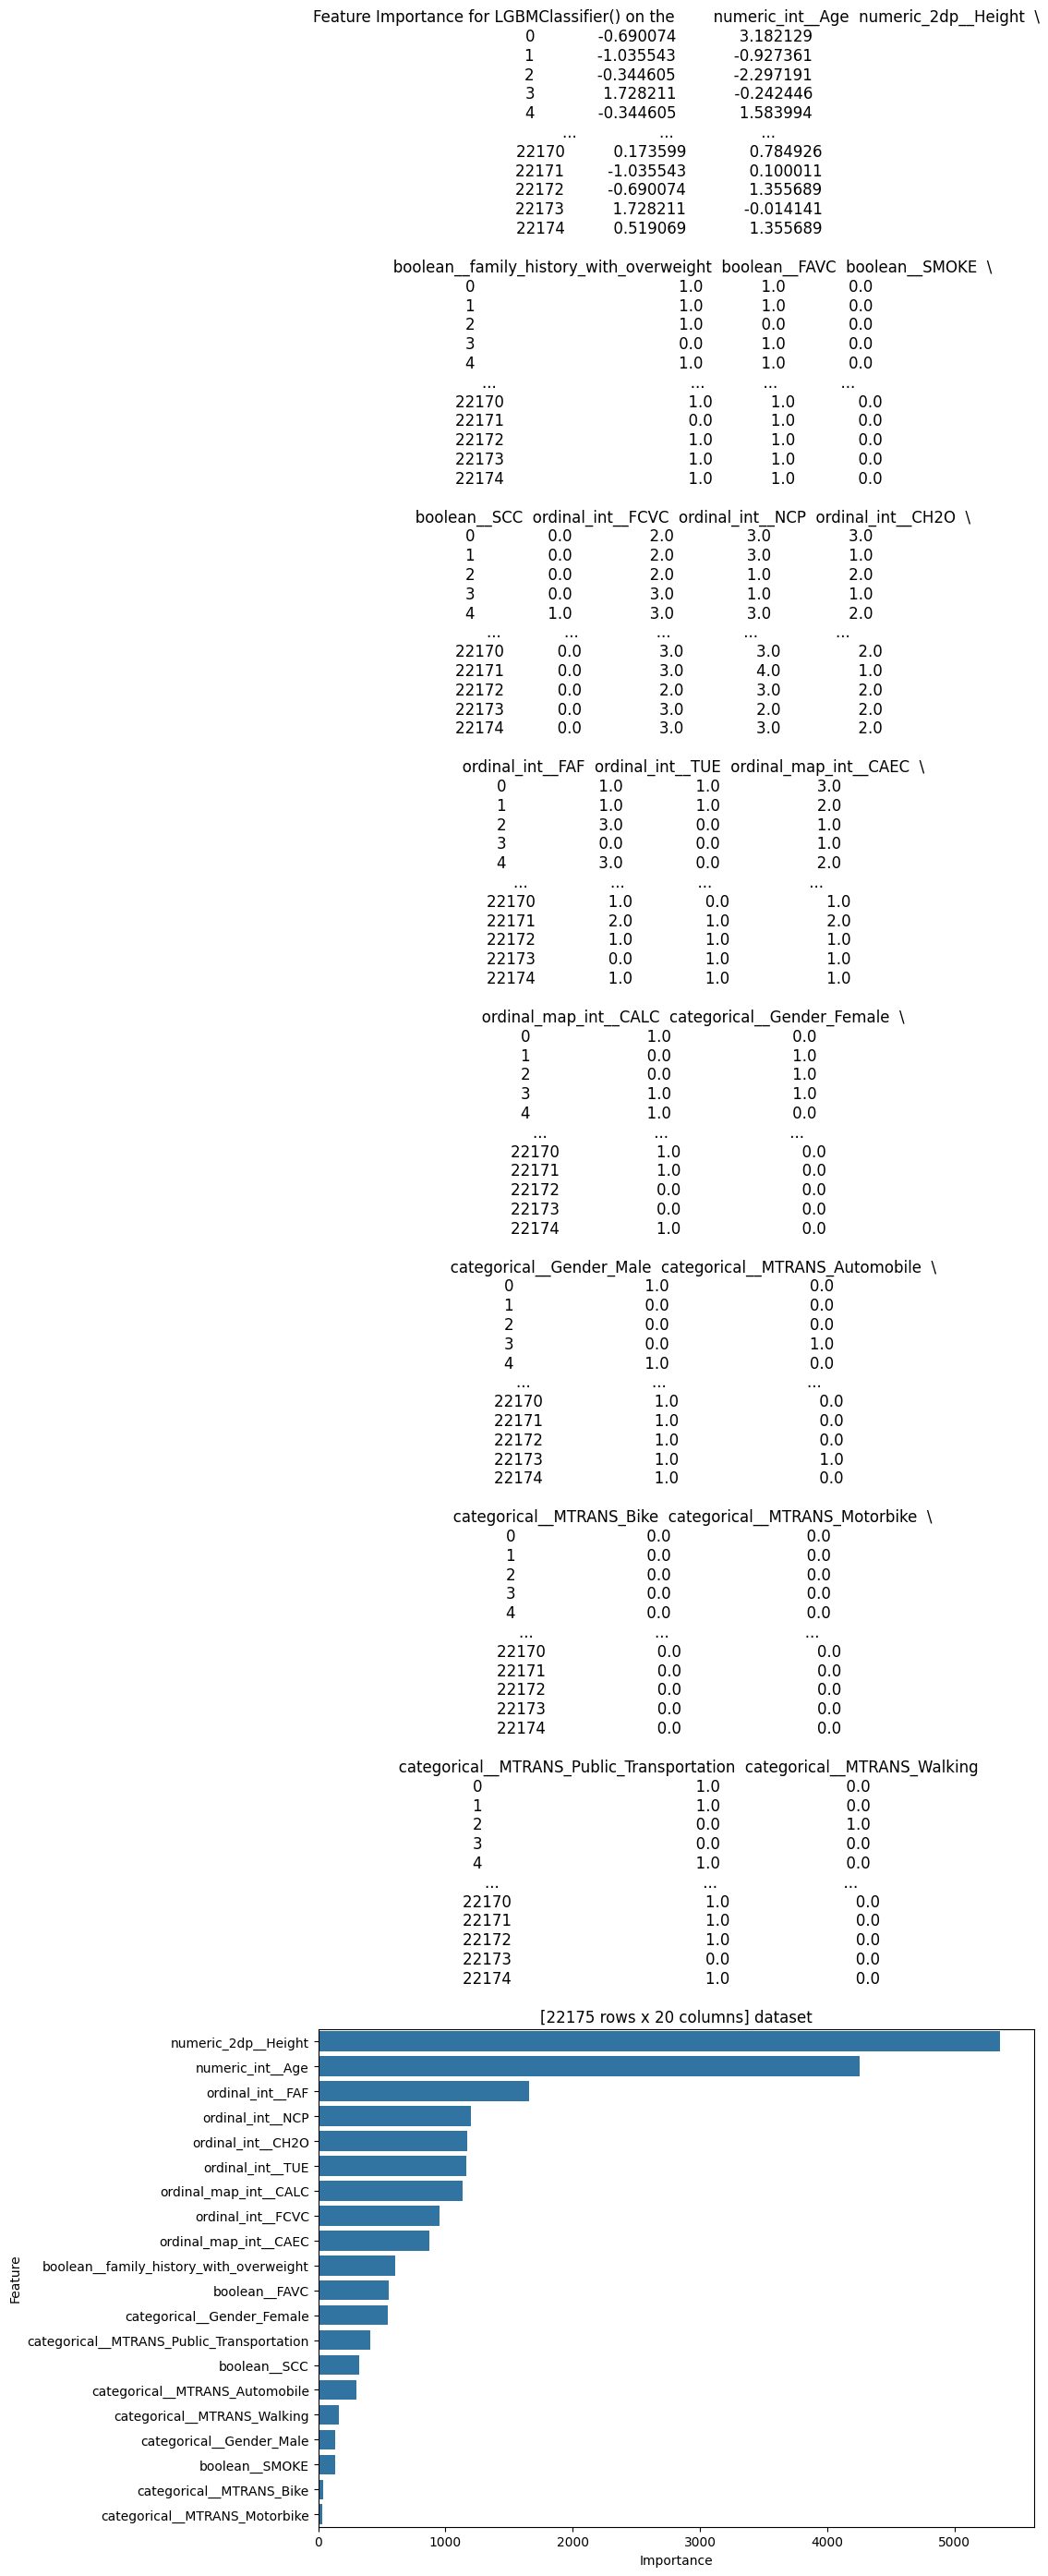

In [ ]:
# Check feature importance
def plot_feature_importance(model, X_train):
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance for {model} on the {X_train} dataset')
    plt.show()

# Feature importance for all datasets
for approach, datasets in approaches.items():
    for dataset in datasets:
        # Load the preprocessed data
        X_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_train.csv")
        y_train = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_train.csv")
        X_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/X_test.csv")
        y_test = pd.read_csv(f"./datasets/preprocessed/{approach}/{dataset}/y_test.csv")

        
        # Create the model
        model = lgb.LGBMClassifier()

        # Fit the model
        model.fit(X_train, y_train)

        # Plot feature importance
        plot_feature_importance(model, X_train)